In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
from curlyBrace import curlyBrace
import random

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

In [2]:
qid = 7638
q = Query.objects.get(pk=qid)

In [3]:
docs = q.doc_set.all()
n_docs = docs.count()
print(n_docs)

74968


In [4]:
screened_docs = set(DocOwnership.objects.filter(tag__query=q,relevant__gt=0).values_list('doc__id',flat=True))
n_screened = len(screened_docs)
n_screened

9719

In [5]:
db1_docs = set(DocOwnership.objects.filter(tag__query=q,relevant=1).values_list('doc__id',flat=True))
print(len(db1_docs))

3444


In [6]:
db2_cat = Category.objects.get(pk=363)
db2_docs = Doc.objects.filter(category=db2_cat)
n_db2_docs = db2_docs.count()

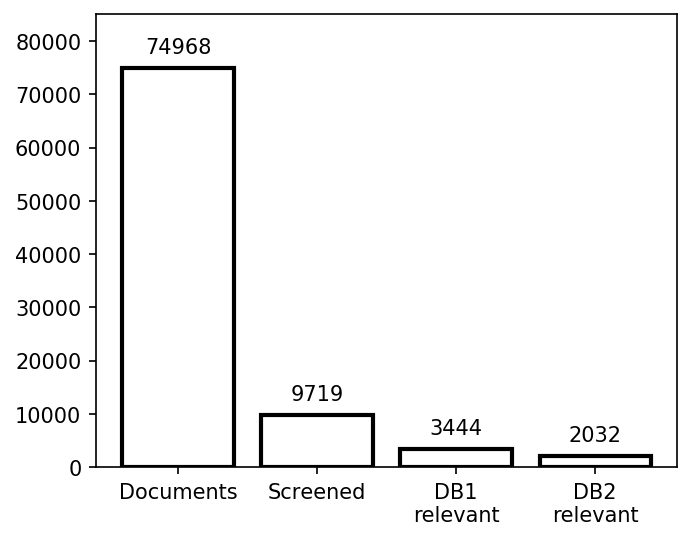

In [7]:
fig, ax = plt.subplots(figsize=(5,4),dpi=150)

x = [0,1,2,3]
y = [n_docs, n_screened, len(db1_docs), n_db2_docs]
xlab = ["Documents","Screened","DB1\nrelevant", "DB2\nrelevant"]

ax.bar(
    x, y,
    color="none",
    linewidth=2,
    edgecolor="black"
)

ymax = ax.get_ylim()[1]

for i,n in enumerate(y):
    ax.text(
        i,n+ymax*0.05,n,
        ha="center",
        va="center"
    )
    
ax.set_ylim(ymax=ymax*1.08)

ax.set_xticks(x)
ax.set_xticklabels(xlab)

plt.show()


In [8]:
dbs = ["WoS","scopus","pop"]
id_sets = [
    set(docs.values_list('pk',flat=True)),
    screened_docs,
    db1_docs,
    set(db2_docs.values_list('pk',flat=True))
]

doctype_db = []

for i, (lab, dids) in enumerate(zip(xlab,id_sets)):
    print("\n###")
    print(lab, len(dids))      
    total = len(dids)
    for db in dbs:
        print(db)
        qs = Query.objects.filter(project=q.project,database=db)
        print(qs)
        db_ids = set(Doc.objects.filter(
            query__in=qs,pk__in=dids
        ).values_list('pk', flat=True))
        dids = dids - db_ids
        print(len(db_ids))
        doctype_db.append({
            "doc_type": lab,
            "db": db,
            "total": total,
            "ndocs": len(db_ids),
            "index": i
        })


###
Documents 74968
WoS
<QuerySet [<Query: medline_extra>, <Query: wos_extra>, <Query: medline>, <Query: medline>, <Query: WoSCC>]>
47509
scopus
<QuerySet [<Query: scopus_extra>, <Query: Scopus>]>
16577
pop
<QuerySet [<Query: Google Scholar upload 2 of 2>, <Query: Google Scholar upload 1 of 2>]>
10564

###
Screened 9719
WoS
<QuerySet [<Query: medline_extra>, <Query: wos_extra>, <Query: medline>, <Query: medline>, <Query: WoSCC>]>
7482
scopus
<QuerySet [<Query: scopus_extra>, <Query: Scopus>]>
2145
pop
<QuerySet [<Query: Google Scholar upload 2 of 2>, <Query: Google Scholar upload 1 of 2>]>
58

###
DB1
relevant 3444
WoS
<QuerySet [<Query: medline_extra>, <Query: wos_extra>, <Query: medline>, <Query: medline>, <Query: WoSCC>]>
2719
scopus
<QuerySet [<Query: scopus_extra>, <Query: Scopus>]>
693
pop
<QuerySet [<Query: Google Scholar upload 2 of 2>, <Query: Google Scholar upload 1 of 2>]>
21

###
DB2
relevant 2029
WoS
<QuerySet [<Query: medline_extra>, <Query: wos_extra>, <Query: medline>,

In [9]:
q = Query.objects.get(pk=7507)
q.doc_set.count()

64504

In [10]:
df = pd.DataFrame.from_dict(doctype_db)
df.head()

,doc_type,db,total,ndocs,index
0,Documents,WoS,74968,47509,0
1,Documents,scopus,74968,16577,0
2,Documents,pop,74968,10564,0
3,Screened,WoS,9719,7482,1
4,Screened,scopus,9719,2145,1


In [132]:
df['index'].unique()

array([0, 1, 2, 3])

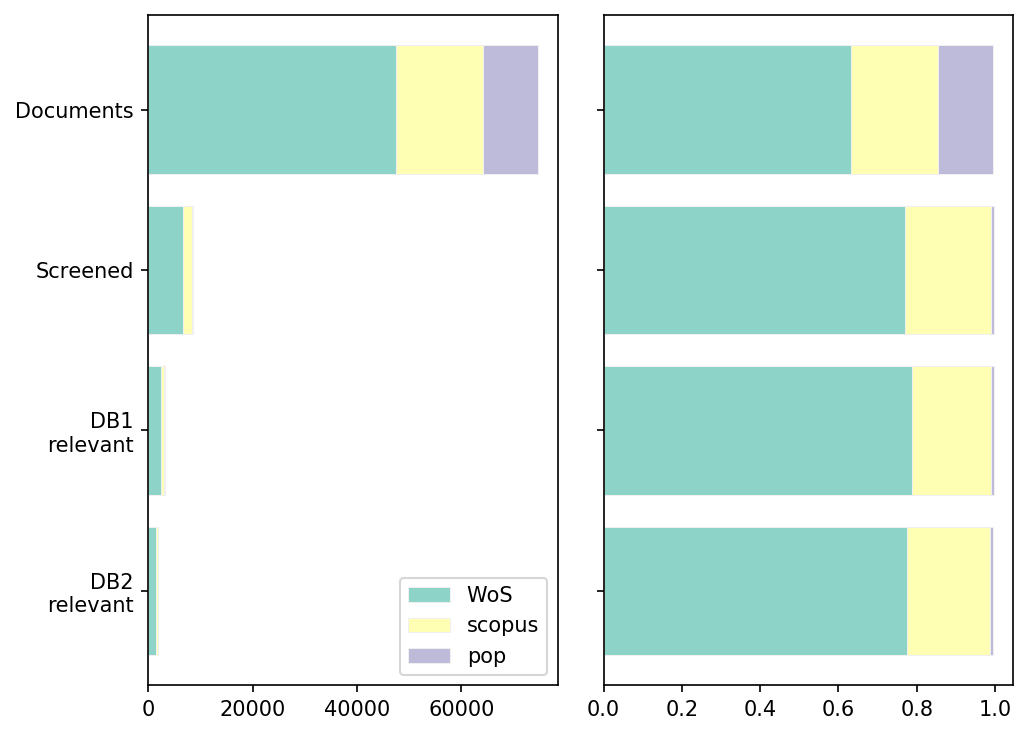

In [135]:
import palettable.colorbrewer.qualitative as palettes
fig, axs = plt.subplots(1,2, sharey=True, figsize=(7,5),dpi=150)
cols = palettes.Set3_4.hex_colors
tickindex = df.groupby(['index','doc_type']).count().reset_index()
for i, (name,group) in enumerate(df.groupby(['index','doc_type'])):
    l = 0
    pl = 0
    for j, d in group.reset_index().iterrows():
        if i==0:
            label=d['db']
        else:
            label=None
        axs[0].barh(
            -i, d['ndocs'], left=l,
            color=cols[j],
            edgecolor="#f0f0f0",
            linewidth=0.5, label=label
        )
        l+=d['ndocs']
        axs[1].barh(
            -i, d['ndocs']/d['total'], left=pl,
            color=cols[j],
            edgecolor="#f0f0f0",
            linewidth=0.5
        )
        pl+=(d['ndocs']/d['total'])

axs[0].legend(loc="lower right")
axs[0].set_yticks(tickindex['index']*-1)
axs[0].set_yticklabels(tickindex['doc_type'])
    
fig.tight_layout()
plt.show()

In [138]:
df.to_csv('doctables/doc_numbers.csv',index=False)